##### This notebook will contain the python code of the project

## 1. Get the Data of Paris Neighborhoods
In this part I am going to create a first DataFrame that contains data about Paris neighborhoods (Neighborhood, Longitude, Latitude)

**Firsty, we get the needed dependencies**

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


**I have already downloaded the dataset in csv format so let's explore it**

In [2]:
neighborhoods=pd.read_csv('quartier_paris.csv', sep=';')
neighborhoods.head()

,N_SQ_QU,C_QU,C_QUINSEE,L_QU,C_AR,N_SQ_AR,PERIMETRE,SURFACE,Geometry X Y,Geometry,OBJECTID,LONGUEUR
0,750000010,10,7510302,Enfants-Rouges,3,750000003,2139.625388,271750.323937,"48.863887392, 2.36312330099","{""type"": ""Polygon"", ""coordinates"": [[[2.367101...",50,2139.535591
1,750000016,16,7510404,Notre-Dame,4,750000004,3283.163371,378252.153674,"48.8528955862, 2.35277501212","{""type"": ""Polygon"", ""coordinates"": [[[2.361313...",56,3282.999717
2,750000018,18,7510502,Jardin-des-Plantes,5,750000005,4052.729521,798389.398463,"48.8419401934, 2.35689388962","{""type"": ""Polygon"", ""coordinates"": [[[2.364561...",58,4052.473226
3,750000025,25,7510701,Saint-Thomas-d'Aquin,7,750000007,3827.253353,826559.436780,"48.8552632694, 2.32558765258","{""type"": ""Polygon"", ""coordinates"": [[[2.322133...",7,3827.053421
4,750000035,35,7510903,Faubourg-Montmartre,9,750000009,2786.541926,417335.080621,"48.8739346918, 2.34325257947","{""type"": ""Polygon"", ""coordinates"": [[[2.340255...",17,2786.448978


#### The needed columns are :'L_QU' indicates the name, 'Geometry XY' for the latitude and longitude

In [3]:
neighborhoods=neighborhoods[['L_QU','Geometry X Y']]

Let's create Latitude and Longitude Columns from Geometry X Y

In [4]:
Latitude=[]
Longitude=[]
for elt in neighborhoods['Geometry X Y']:
    Latitude.append(elt.split(',')[0].strip(' '))
    Longitude.append(elt.split(',')[1].strip(' '))

In [5]:
neighborhoods['Latitude']=Latitude
neighborhoods['Longitude']=Longitude
neighborhoods.drop('Geometry X Y', axis=1, inplace=True)

In [6]:
neighborhoods.rename(columns={'L_QU':'Neighborhood'}, inplace=True)
neighborhoods.head()

,Neighborhood,Latitude,Longitude
0,Enfants-Rouges,48.863887392,2.36312330099
1,Notre-Dame,48.8528955862,2.35277501212
2,Jardin-des-Plantes,48.8419401934,2.35689388962
3,Saint-Thomas-d'Aquin,48.8552632694,2.32558765258
4,Faubourg-Montmartre,48.8739346918,2.34325257947


In [7]:
neighborhoods['Latitude']=neighborhoods['Latitude'].apply(float)
neighborhoods['Longitude']=neighborhoods['Longitude'].apply(float)


**Now that we have the coordinates of each neighborhood, it would be nice to visualize them on a map using Folium library**  
First we use **geocopy** to get the coordinates of Paris

In [8]:
address = 'Paris, France'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Lat:', latitude, 'Long:', longitude)

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.18.1" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


Lat: 48.8566101 Long: 2.3514992


In [9]:
# create map of Paris using latitude and longitude values
map_paris = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng , neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_paris

## 2. Use the Foursquare API to get data about the neighborhoods and their venues

First we define the credentials and the versions of the Foursquare API

In [10]:
CLIENT_ID = 'BKFOSIM2OYDU4YH4VTEKP4OBR5M2OC1JET20BCZJGUQ5RM02' # My Foursquare ID
CLIENT_SECRET = 'VDZXDEXA44TNI5H4WB5KNJEUEFOIAOTVVPJGEHH5Z3ZOGQND' # My Foursquare Secret
VERSION = '20181230' # Foursquare API version

print('My credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentails:
CLIENT_ID: BKFOSIM2OYDU4YH4VTEKP4OBR5M2OC1JET20BCZJGUQ5RM02
CLIENT_SECRET:VDZXDEXA44TNI5H4WB5KNJEUEFOIAOTVVPJGEHH5Z3ZOGQND


#### To make things clear before generelazing, let's explore one of the neighborhoods to know what informations we can get from the API

In [11]:
neighborhoods.iloc[0]

Neighborhood    Enfants-Rouges
Latitude               48.8639
Longitude              2.36312
Name: 0, dtype: object

As we can see, the first neighborhood is **Enfants-Rouges**, so let's explore it

In [12]:
enf_roug=neighborhoods.iloc[0]
enf_roug_lat=enf_roug['Latitude']
enf_roug_long=enf_roug['Longitude']

Now, let's get the top 30 (The agency needs only 10 per neighborhood, but the number decreases with filtering) venues that are in Enfants-Rouges within a radius of 500 meters.

In [13]:
url='https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius=500&limit=30'.format(CLIENT_ID, 
                                                                                                                CLIENT_SECRET,
                                                                                                               VERSION,
                                                                                                               enf_roug_lat,
                                                                                                               enf_roug_long)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c2930c64c1f677d29b168a3'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Enfants-Rouges',
  'headerFullLocation': 'Enfants-Rouges, Paris',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 160,
  'suggestedBounds': {'ne': {'lat': 48.868387396500005,
    'lng': 2.369951000269394},
   'sw': {'lat': 48.8593873875, 'lng': 2.3562956017106056}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d974096a2c654814aa6d353',
       'name': 'Mmmozza',
       'location': {'address': '57 rue de Bretagne',
        'lat': 48.86403341736561,
        'lng': 2.360807525409116,
        'labeledLatLngs': [{'label': 'display',
          'lat': 48.864

We can see that all the information is in the **items** key.  
Before we proceed, let's create the **get_category_type** function that extracts the category of the venue

In [14]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Let's create a dataframe for the nearby venues from the result

In [15]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,id,name,categories,lat,lng
0,4d974096a2c654814aa6d353,Mmmozza,Sandwich Place,48.864033,2.360808
1,4b68a117f964a520c8832be3,Le Barav,Wine Bar,48.865166,2.363155
2,501ab9cfe4b089ae3961a041,L'Îlot,Seafood Restaurant,48.864666,2.363317
3,4b75734cf964a5202c0d2ee3,Marché des Enfants Rouges,Farmers Market,48.862806,2.361996
4,4b93cba4f964a520155234e3,Square du Temple,Park,48.864475,2.360816


#### Let's use Foursquare again to get the ratings of each venue

In [16]:
'''
ratings=[]
for venue_id in nearby_venues['id']:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        ratings.append(result['response']['venue']['rating'])
    except:
        ratings.append(np.NaN)
'''

"\nratings=[]\nfor venue_id in nearby_venues['id']:\n    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)\n    result = requests.get(url).json()\n    try:\n        ratings.append(result['response']['venue']['rating'])\n    except:\n        ratings.append(np.NaN)\n"

In [17]:
''' nearby_venues['rating']=ratings
nearby_venues.head() '''

" nearby_venues['rating']=ratings\nnearby_venues.head() "

### Now let's repeat the same process for all the neighborhoods


In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit=30'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(v['venue']['id'],
            name, 
            lat, 
            lng,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    
    
    nearby_venues.columns = ['Id',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    
    return(nearby_venues)

In [53]:
paris_venues=getNearbyVenues(neighborhoods['Neighborhood'], neighborhoods['Latitude'], neighborhoods['Longitude'])
paris_venues.head()

,Id,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4d974096a2c654814aa6d353,Enfants-Rouges,48.863887,2.363123,Mmmozza,48.864033,2.360808,Sandwich Place
1,4b68a117f964a520c8832be3,Enfants-Rouges,48.863887,2.363123,Le Barav,48.865166,2.363155,Wine Bar
2,501ab9cfe4b089ae3961a041,Enfants-Rouges,48.863887,2.363123,L'Îlot,48.864666,2.363317,Seafood Restaurant
3,4b75734cf964a5202c0d2ee3,Enfants-Rouges,48.863887,2.363123,Marché des Enfants Rouges,48.862806,2.361996,Farmers Market
4,4b93cba4f964a520155234e3,Enfants-Rouges,48.863887,2.363123,Square du Temple,48.864475,2.360816,Park


In [54]:
len(paris_venues)

2338

### As the agency is only interested in some categories that could interest its customers we will filter our dataframe based on some venue categories

Let's first explore the available categories

In [55]:
paris_venues['Venue Category'].unique()

array(['Sandwich Place', 'Wine Bar', 'Seafood Restaurant',
       'Farmers Market', 'Park', 'Cocktail Bar', 'Japanese Restaurant',
       'Italian Restaurant', 'Speakeasy', 'French Restaurant',
       'Chocolate Shop', 'Burger Joint', 'Tea Room', 'Bookstore',
       'Cheese Shop', 'Coffee Shop', 'Bistro', 'Boutique',
       'Clothing Store', 'Dessert Shop', 'Flower Shop', 'Breakfast Spot',
       'Church', 'Scenic Lookout', 'Ice Cream Shop', 'Trail', 'Plaza',
       'Auvergne Restaurant', 'Bakery', 'Mexican Restaurant',
       'Miscellaneous Shop', 'Memorial Site', 'Cultural Center',
       'Science Museum', 'Spa', 'Botanical Garden', 'Peruvian Restaurant',
       'Museum', 'Garden', 'Gym / Fitness Center', 'Moroccan Restaurant',
       'Greek Restaurant', 'Historic Site', 'Creperie',
       'Vietnamese Restaurant', 'Zoo Exhibit', 'Zoo', 'Pizza Place',
       'Shoe Store', 'Art Museum', 'Pastry Shop', 'Art Gallery',
       'Gluten-free Restaurant', 'Tailor Shop', 'Hotel',
       'Ameri

In the following i'm going to create a list of the intersting categories, and two functions to filter the dataframe

In [56]:
interesting_categories=['Hotel', 'French Restaurant','Asian Restaurant', 'Italian Restaurant','Souvenir Shop', 'Antique Shop' 
                        'Moroccan Restaurant', 'Museum', 'Park','Monument', 'Plaza', 'Shopping Mall', 'Clothing Store']
#Function that filters the DataFrame based on the categories
def contains_category(elt):
    for cat in interesting_categories:
        if cat in elt:
            return True


def filter_category(df):
    df=df[df['Venue Category'].apply(contains_category)==True]
    return df

paris_venues=filter_category(paris_venues)
paris_venues.reset_index(drop=True, inplace=True)


In [57]:
paris_venues.head(3)

,Id,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,4b93cba4f964a520155234e3,Enfants-Rouges,48.863887,2.363123,Square du Temple,48.864475,2.360816,Park
1,583025d07ff1e43c19cd8599,Enfants-Rouges,48.863887,2.363123,Biglove Caffè,48.862063,2.363557,Italian Restaurant
2,4dcad848c65bebb82f42d5c5,Enfants-Rouges,48.863887,2.363123,L'Aller Retour,48.865247,2.363203,French Restaurant


In [58]:
paris_venues.shape

(826, 8)

In [59]:
print('There are {} categories available.'.format(paris_venues['Venue Category'].nunique()))

There are 18 categories available.


**One last important thing to check, is to see whether we have duplicates in Venues**

In [60]:
n_venues=len(paris_venues)
n_unique=paris_venues['Venue'].nunique()
print('There are {} venues, and {} unique venues'.format(n_venues, n_unique))

There are 826 venues, and 702 unique venues


We can see that we have less unique venues than the total number of venues, so we will remove the duplicates so as not to get confused

In [61]:
paris_venues.drop_duplicates('Venue', False, inplace=True)
len(paris_venues)

583

In [62]:
paris_venues.head()

,Id,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
2,4dcad848c65bebb82f42d5c5,Enfants-Rouges,48.863887,2.363123,L'Aller Retour,48.865247,2.363203,French Restaurant
4,4bf6ddba5ec320a1eeea85d3,Notre-Dame,48.852896,2.352775,Square Jean XXIII,48.852499,2.351375,Park
5,4adcda12f964a520513621e3,Notre-Dame,48.852896,2.352775,Bel Canto,48.854632,2.354493,French Restaurant
6,4b9ea5cdf964a52094f636e3,Notre-Dame,48.852896,2.352775,Au Vieux Paris d'Arcole,48.854196,2.350312,French Restaurant
7,508ad773e4b01ceeb2bab8d4,Notre-Dame,48.852896,2.352775,Comme chai Toi,48.851749,2.349319,French Restaurant


In [63]:
test=paris_venues.set_index('Neighborhood')
joindf=neighborhoods.join(test, on='Neighborhood', how='inner')
neighborhoods=joindf[neighborhoods.columns]
neighborhoods.drop_duplicates(inplace=True)

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [64]:
neighborhoods.reset_index(inplace=True, drop=True)

Now we add venues ratings

In [65]:
'''ratings=[]
for venue_id in paris_venues['Id']:
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        ratings.append(result['response']['venue']['rating'])
    except:
        ratings.append(np.NaN)
'''

"ratings=[]\nfor venue_id in paris_venues['Id']:\n    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)\n    result = requests.get(url).json()\n    try:\n        ratings.append(result['response']['venue']['rating'])\n    except:\n        ratings.append(np.NaN)\n"

In [66]:
'''paris_venues['Venue Rating']=ratings
paris_venues.head() '''

"paris_venues['Venue Rating']=ratings\nparis_venues.head() "

In [67]:
'''paris_venues['Venue Rating'].unique() '''

"paris_venues['Venue Rating'].unique() "

Let's check the shape of this DataFrame

In [68]:
paris_venues.shape

(583, 8)

Let's check how many venues were returned for each neighborhood

In [69]:
paris_venues.groupby('Neighborhood').count()['Id']

Neighborhood
Amérique                   8
Archives                   4
Arsenal                   13
Arts-et-Metiers            4
Auteuil                    6
Batignolles                4
Bel-Air                   10
Belleville                 4
Bercy                      7
Chaillot                  17
Champs-Elysées            15
Charonne                   4
Chaussée-d'Antin           3
Clignancourt               4
Combat                     4
Croulebarbe                8
Ecole-Militaire            7
Enfants-Rouges             1
Epinettes                  6
Europe                    13
Faubourg-Montmartre        8
Faubourg-du-Roule         19
Folie-Méricourt            6
Gaillon                    3
Gare                       6
Grandes-Carrières          8
Grenelle                   9
Gros-Caillou              23
Halles                     8
Hôpital-Saint-Louis        4
Invalides                 19
Jardin-des-Plantes         3
Javel 15Art               14
La Chapelle                4
M

Let's remove the neighborhoods that have less than 10 venues to meet the requirements

In [70]:
'''more_than_10=paris_venues.groupby('Neighborhood').count()>=10
more_than_10.drop(more_than_10[more_than_10['Venue'] == False].index, inplace=True)
print(len(more_than_10))
joined_df=paris_venues.join(more_than_10, how='inner', on='Neighborhood', rsuffix='_')
paris_venues=joined_df[list(paris_venues.columns)]

joined_df_2=neighborhoods.join(more_than_10, how='inner', on='Neighborhood', rsuffix='_')
joined_df_2.drop_duplicates('Neighborhood', inplace=True)
neighborhoods=joined_df_2[list(neighborhoods.columns)]'''

"more_than_10=paris_venues.groupby('Neighborhood').count()>=10\nmore_than_10.drop(more_than_10[more_than_10['Venue'] == False].index, inplace=True)\nprint(len(more_than_10))\njoined_df=paris_venues.join(more_than_10, how='inner', on='Neighborhood', rsuffix='_')\nparis_venues=joined_df[list(paris_venues.columns)]\n\njoined_df_2=neighborhoods.join(more_than_10, how='inner', on='Neighborhood', rsuffix='_')\njoined_df_2.drop_duplicates('Neighborhood', inplace=True)\nneighborhoods=joined_df_2[list(neighborhoods.columns)]"

In [71]:
print(len(neighborhoods))

76


Let's check the shape of our DataFrame again

In [72]:
paris_venues.shape

(583, 8)

Let's see how many categories we have, to give the agency the number of choices they have for types of venues to visit

In [73]:
print('There are {} categories available.'.format(paris_venues['Venue Category'].nunique()))

There are 17 categories available.


## 3. Data Analysis: Let's analyse our Neighborhoods

Let's create a one hone encoding dataframe from categories

In [74]:
# one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Neighborhood,Art Museum,Asian Restaurant,Clothing Store,French Restaurant,History Museum,Hotel,Hotel Bar,Italian Restaurant,Monument / Landmark,Museum,Park,Pedestrian Plaza,Plaza,Science Museum,Shopping Mall,Shopping Plaza,Southwestern French Restaurant
2,Enfants-Rouges,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Notre-Dame,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,Notre-Dame,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,Notre-Dame,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
7,Notre-Dame,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [75]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
paris_grouped.head()

,Neighborhood,Art Museum,Asian Restaurant,Clothing Store,French Restaurant,History Museum,Hotel,Hotel Bar,Italian Restaurant,Monument / Landmark,Museum,Park,Pedestrian Plaza,Plaza,Science Museum,Shopping Mall,Shopping Plaza,Southwestern French Restaurant
0,Amérique,0.00,0.0,0.00,0.625000,0.0,0.000000,0.0,0.125000,0.0,0.000000,0.125000,0.000000,0.125000,0.0,0.0,0.000000,0.0
1,Archives,0.25,0.0,0.25,0.500000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,Arsenal,0.00,0.0,0.00,0.461538,0.0,0.076923,0.0,0.076923,0.0,0.076923,0.076923,0.076923,0.153846,0.0,0.0,0.000000,0.0
3,Arts-et-Metiers,0.00,0.0,0.00,0.250000,0.0,0.250000,0.0,0.250000,0.0,0.250000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,Auteuil,0.00,0.0,0.00,0.500000,0.0,0.166667,0.0,0.000000,0.0,0.166667,0.000000,0.000000,0.000000,0.0,0.0,0.166667,0.0


#### Let's print each neighborhood along with the top 5 most common venues to help the agency know what are the characterises each neighborhood

In [76]:
num_top_venues = 5

for hood in paris_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amérique----
                venue  freq
0   French Restaurant  0.62
1                Park  0.12
2               Plaza  0.12
3  Italian Restaurant  0.12
4          Art Museum  0.00


----Archives----
               venue  freq
0  French Restaurant  0.50
1         Art Museum  0.25
2     Clothing Store  0.25
3               Park  0.00
4     Shopping Plaza  0.00


----Arsenal----
                venue  freq
0   French Restaurant  0.46
1               Plaza  0.15
2    Pedestrian Plaza  0.08
3               Hotel  0.08
4  Italian Restaurant  0.08


----Arts-et-Metiers----
                venue  freq
0   French Restaurant  0.25
1               Hotel  0.25
2  Italian Restaurant  0.25
3              Museum  0.25
4          Art Museum  0.00


----Auteuil----
               venue  freq
0  French Restaurant  0.50
1     Shopping Plaza  0.17
2              Hotel  0.17
3             Museum  0.17
4         Art Museum  0.00


----Batignolles----
               venue  freq
0  French Restaurant   1.

**Let's create a dataframe for that**

In [77]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [78]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Amérique,French Restaurant,Plaza,Park,Italian Restaurant,Southwestern French Restaurant
1,Archives,French Restaurant,Art Museum,Clothing Store,Italian Restaurant,Asian Restaurant
2,Arsenal,French Restaurant,Plaza,Hotel,Pedestrian Plaza,Park
3,Arts-et-Metiers,Italian Restaurant,French Restaurant,Hotel,Museum,Southwestern French Restaurant
4,Auteuil,French Restaurant,Hotel,Museum,Shopping Plaza,Southwestern French Restaurant


## 4. Clustering the neighborhoods

#### We will use the K-Means algorithm for clustering, and the elbow method for evaluation -Both the algorithm and the elbow method are explained in the report-

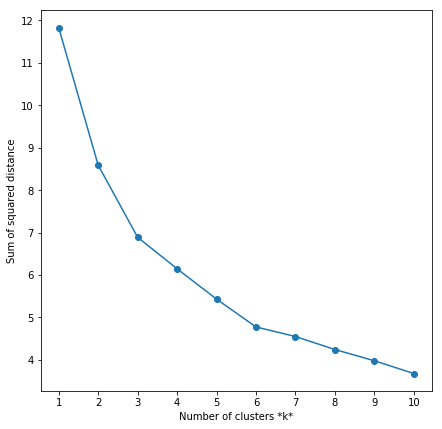

In [79]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sse = []
list_k = list(range(1, 11))
X = paris_grouped.drop('Neighborhood', 1)
for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(7,7))
plt.plot(list_k, sse, '-o')
plt.xticks(range(1,11))
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

We can see that the elbow point is at **K=6**

In [80]:
km.n_clusters=6
km.fit(X)
print(len(km.labels_))
km.labels_[0:20]

76


array([0, 5, 5, 2, 5, 0, 5, 5, 3, 1, 5, 0, 1, 0, 4, 5, 1, 0, 5, 5],
      dtype=int32)

#### Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [81]:
paris_merged = neighborhoods

# add clustering labels
paris_merged['Cluster Labels'] = km.labels_

# merge paris_grouped with paris_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

paris_merged.head() # 


/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Enfants-Rouges,48.863887,2.363123,0,French Restaurant,Southwestern French Restaurant,Italian Restaurant,Asian Restaurant,Clothing Store
1,Notre-Dame,48.852896,2.352775,5,French Restaurant,Plaza,Park,Southwestern French Restaurant,Hotel Bar
2,Jardin-des-Plantes,48.841940,2.356894,5,Museum,Plaza,Southwestern French Restaurant,Hotel Bar,Asian Restaurant
3,Saint-Thomas-d'Aquin,48.855263,2.325588,2,French Restaurant,Hotel,Art Museum,Italian Restaurant,Asian Restaurant
4,Faubourg-Montmartre,48.873935,2.343253,5,French Restaurant,Hotel,Pedestrian Plaza,Southwestern French Restaurant,Italian Restaurant


In [86]:
paris_merged.to_csv('paris_merged')
neighborhoods.to_csv('neighborhoods')
paris_grouped.to_csv('paris_grouped')
neighborhoods_venues_sorted.to_csv('neighborhoods_venues_sorted')
paris_venues.to_csv('paris_venues')

In [83]:
# create map
kclusters=6
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 0.9, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

## 5. Examine the clusters 
#### In this step we will explore the characteristics of each cluster 

Let's see how many neighborhoods we have in each cluster

In [101]:
grpby=paris_merged[['Neighborhood','Cluster Labels']].groupby('Cluster Labels')

In [102]:
grpby.count().sort_values('Neighborhood', ascending=False)

,Neighborhood
Cluster Labels,
5,25
1,19
0,14
2,10
4,5
3,3


### Now let's see what characterises each of the clusters

First I will create a function to visualize the most trending categories in each cluster

In [139]:
def analyse_cluster(cluster):
    cluster=cluster.set_index('Neighborhood')
    cluster_joined=paris_grouped.join(cluster, on='Neighborhood', how='inner')
    cluster_joined=cluster_joined[paris_grouped.columns]
    cluster_joined.reset_index(drop=True, inplace=True)
    plt.figure(figsize=(15,7))
    cluster_joined.drop('Neighborhood',1).sum().sort_values(ascending=False).plot(kind='bar')

In [140]:
cluster1=paris_merged.loc[paris_merged['Cluster Labels'] == 0, paris_merged.columns[[0] + list(range(4, paris_merged.shape[1]))]]
cluster2=paris_merged.loc[paris_merged['Cluster Labels'] == 1, paris_merged.columns[[0] + list(range(4, paris_merged.shape[1]))]]
cluster3=paris_merged.loc[paris_merged['Cluster Labels'] == 2, paris_merged.columns[[0] + list(range(4, paris_merged.shape[1]))]]
cluster4=paris_merged.loc[paris_merged['Cluster Labels'] == 3, paris_merged.columns[[0] + list(range(4, paris_merged.shape[1]))]]
cluster5=paris_merged.loc[paris_merged['Cluster Labels'] == 4, paris_merged.columns[[0] + list(range(4, paris_merged.shape[1]))]]
cluster6=paris_merged.loc[paris_merged['Cluster Labels'] == 5, paris_merged.columns[[0] + list(range(4, paris_merged.shape[1]))]]

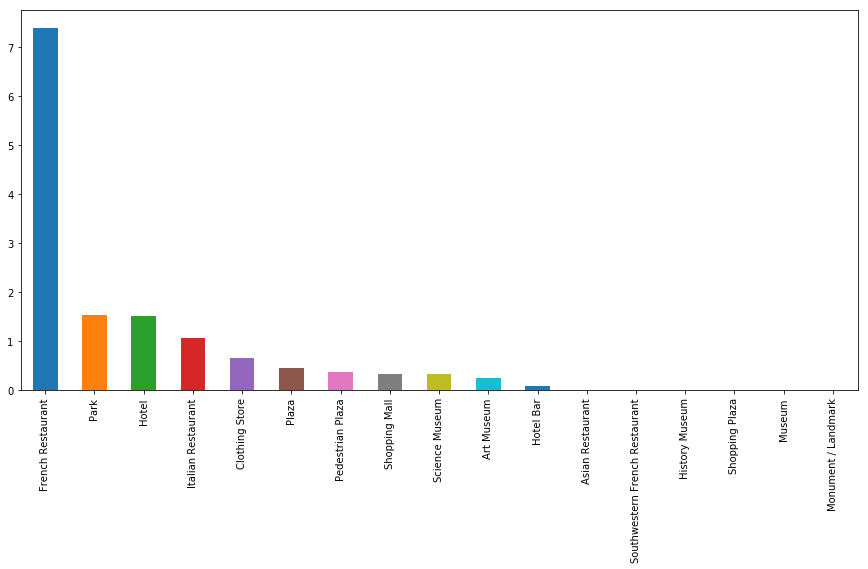

In [141]:
analyse_cluster(cluster1)

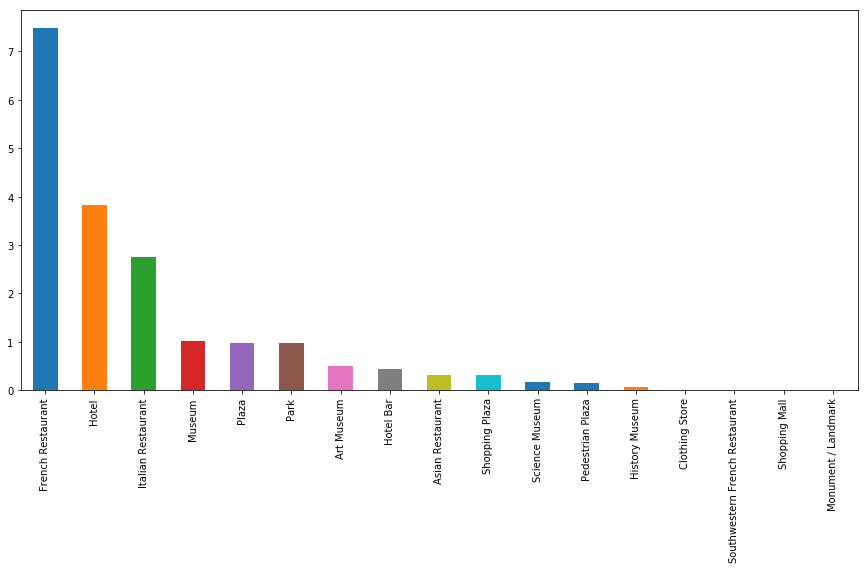

In [142]:
analyse_cluster(cluster2)

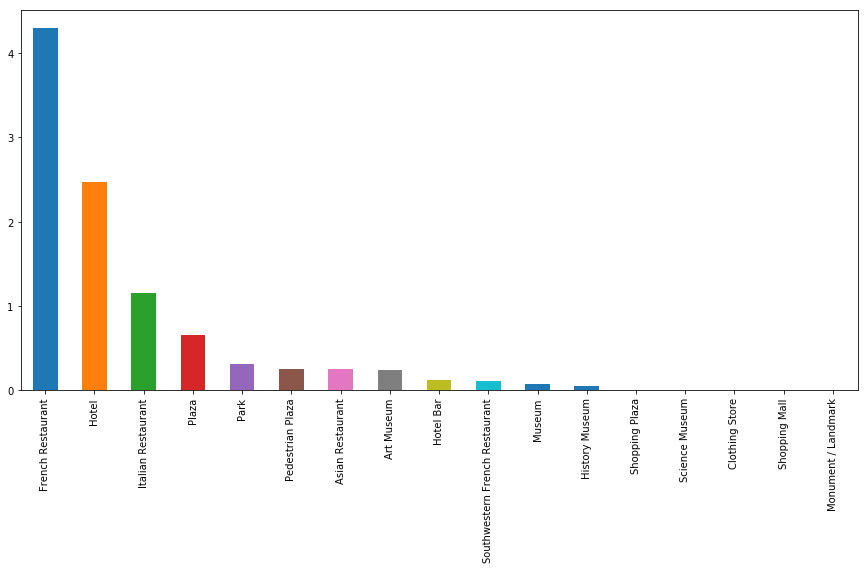

In [143]:
analyse_cluster(cluster3)

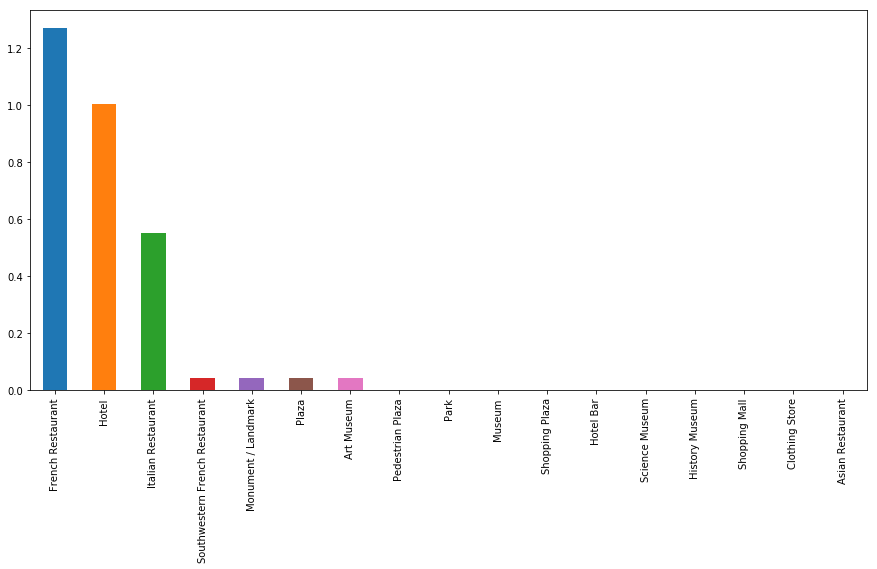

In [144]:
analyse_cluster(cluster4)

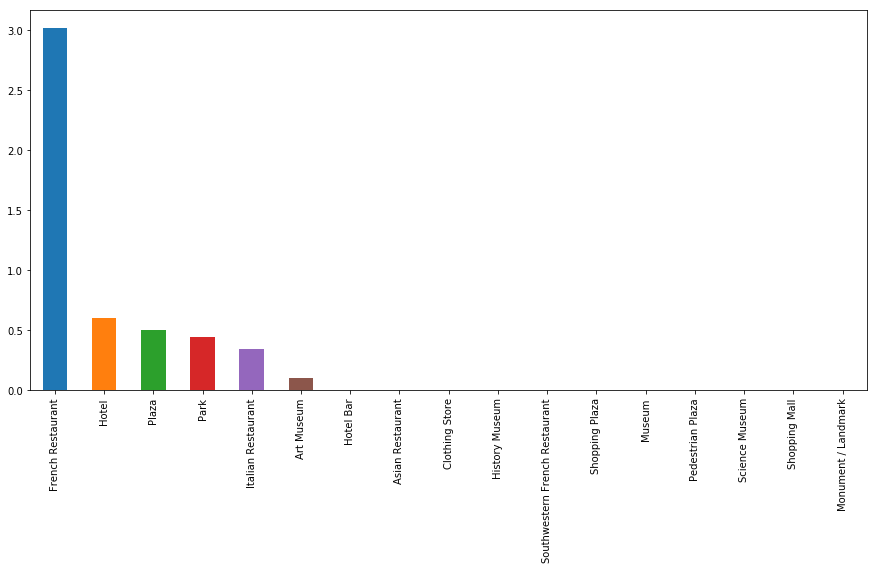

In [145]:
analyse_cluster(cluster5)

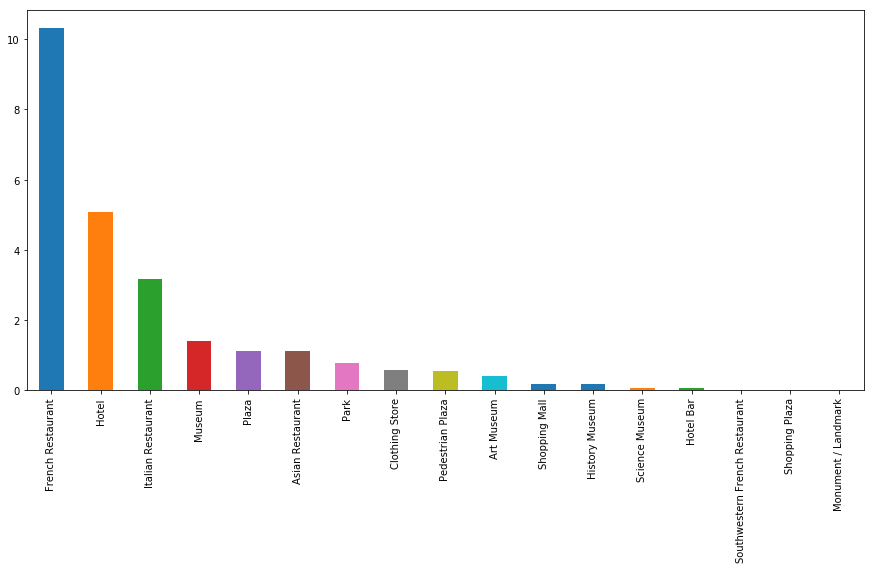

In [146]:
analyse_cluster(cluster6)

## 6. Explore some of the Tips

In [154]:
df_tips=paris_venues[['Id','Neighborhood','Venue','Venue Category']]

In [156]:
CLIENT_ID = 'RRJVJSV5MQJVVGEJ3WNJWD04FEWRBWVID5UIXNGA4SOT5A5O' # your Foursquare ID
CLIENT_SECRET = 'J1K30WI4K4GGKQIIV4Y3ODKVMGXNFC3043CRSRNT4NBWGTSE' # your Foursquare Secret
VERSION = '20181230'

In [157]:
pd.set_option('display.max_colwidth', -1)
tips_col=[]
for venue_id in df_tips['Id']:
    url = 'https://api.foursquare.com/v2/venues/{}/tips?client_id={}&client_secret={}&v={}&limit=1'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    results = requests.get(url).json()
    if results['response']['tips']['count']>0:
        tips = results['response']['tips']['items']
        tip = json_normalize(tips)
        tips_col.append(tip['text'].values[0])


KeyError: 'tips'

### I got an error because the cota is exceeded, so let's see the tips we got

In [166]:
tips_col[0:10]

["Fantastic find.  The burrata with pesto, Argentinian steak and chocolate cake was the perfect combination.  Wash it down with a bottle of Pinot noir - quite possibly the smoothest red I've ever had.",
 'A great place to sit down and relax in the shade - also a perfect place to take fantastic photos and see one of the Rose Windows and other architecture of the Notre Dame Cathedral.',
 'Students of the world-famous Paris Conservatory – who are also the waiters -- burst into song several times an evening, performing the arias you adore from Puccini, Verdi, Mozart and more',
 'What a gem. We had the lunch special and it was a bargain. 20 EURO for a starter & main. Mostly locals and random tourist who stumbled upon it. Food really great.',
 'Absolutely loved this place! The tartare is amazing! We also had the veal! Superb atmosphere and service plus great view of the Notre Dame. Best of you book a seat by the windows.',
 'In this romantic restaurant  I had my marriage proposal!The most be

#### Let's visualize the most occuring words in these tips using word clouds

In [167]:
!conda install -c conda-forge wordcloud==1.4.1 --yes

# import package and its set of stopwords
from wordcloud import WordCloud, STOPWORDS

print ('Wordcloud is installed and imported!')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge

The following NEW packages will be INSTALLED:

    wordcloud: 1.4.1-py36_0 conda-forge


wordcloud-1.4.1      | 324 KB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Wordcloud is installed and imported!


We have also tips written in french, so we have to remove french stop-words.  
First I will install stopwords library

In [173]:
!pip install stop-words

  Running setup.py bdist_wheel for stop-words ... done
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [174]:
from stop_words import get_stop_words

stop_words_fr = get_stop_words('french')
stop_words_en = get_stop_words('english')


In [177]:
stopwords=set(stop_words_fr+stop_words_en)

In [178]:
tips_text=''
for tip in tips_col:
    tips_text=tips_text + ' ' + tip

(-0.5, 399.5, 199.5, -0.5)

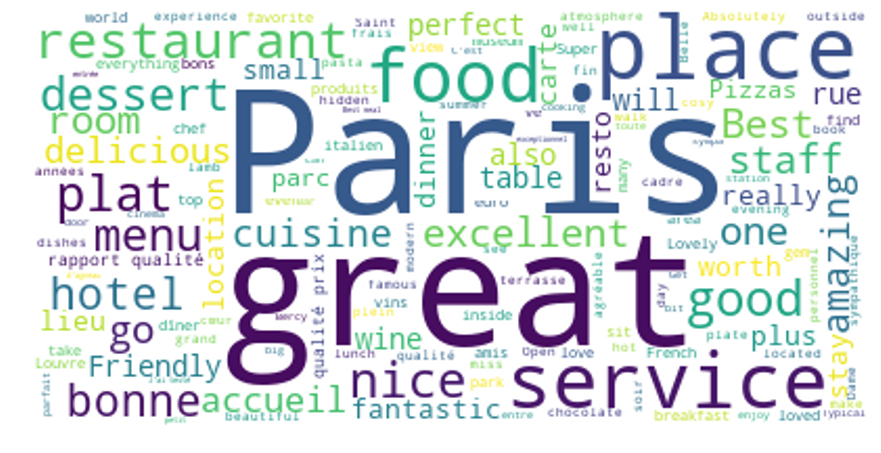

In [180]:
# instantiate a word cloud object
tips_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)
plt.figure(figsize=(15,10))
# generate the word cloud
tips_wc.generate(tips_text)
# display the word cloud
plt.imshow(tips_wc, interpolation='catrom')
plt.axis('off')
